# Projet IA : voyageur de commerce
Marie Magny
Mickael Nabet
Maxime Boyer

## Requirements obligatoires
- Python 3
- matplotlib
- networkx
- numpy

## Requirements optionnels (pour un meilleur affichage avec jupyter notebook sur un PC Windows)
- algorithmx
- jupyter

Tous sauf Python 3 peuvent simplement s'installer via la commande "pip install req" avec matplotlib à la place de req par exemple, etc.

In [1]:
import networkx as nx
import matplotlib.pyplot as plt
from random import randint
import sys

In [2]:
# Fonction pour générer un graphe complet aléatoire avec la possibilité de spécifier un nombre de sommets ainsi
# qu'une borne supérieur pour le poids aléatoire de chaque arrête
def generate_random_graph(nbr_sommets=5, max_poids=10):
    graphe = nx.complete_graph(nbr_sommets)
    nx.set_edge_attributes(graphe, {e: {'weight': randint(1, max_poids)} for e in graphe.edges})
    return graphe

In [3]:
# Fonction avec un exemple de graphe généré à la main
# Il est possible de changer les valeurs des poids et de rajouter d'autres arrêtes en suivant la même syntaxe
# Ajouter une arrête entre le sommet 0 et le sommet 1 rajoutera les sommets au graphe s'ils n'existent pas encore
# dans le graphe
def generate_graph():
    graphe = nx.Graph()
    graphe.add_weighted_edges_from([(0, 1, 2), #(départ, arrivée, poids)
                                    (0, 2, 4),
                                    (1, 2, 8),
                                    (0, 3, 9),
                                    (1, 3, 3),
                                    (2, 3, 1),
                                    (0, 4, 4),
                                    (1, 4, 3),
                                    (2, 4, 10),
                                    (3, 4, 6)])
    return graphe

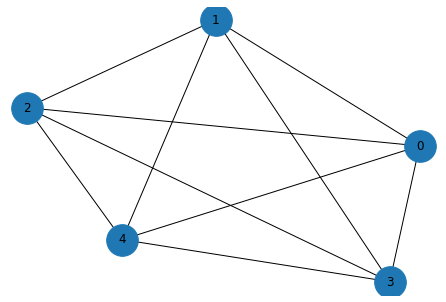

In [4]:
#visualisation
graphe = generate_graph()
nx.draw(graphe, with_labels=True, node_size=1000)
plt.show()

In [5]:
for t in graphe.edges(data=True):
    print(t)

(0, 1, {'weight': 2})
(0, 2, {'weight': 4})
(0, 3, {'weight': 9})
(0, 4, {'weight': 4})
(1, 2, {'weight': 8})
(1, 3, {'weight': 3})
(1, 4, {'weight': 3})
(2, 3, {'weight': 1})
(2, 4, {'weight': 10})
(3, 4, {'weight': 6})


Sinon avec les requirements optionnels, possible d'avoir un meilleur affichage qui permet notamment de voir les poids sur les arrêtes

In [6]:
from algorithmx.networkx import add_graph
from algorithmx import jupyter_canvas

canvas = jupyter_canvas()
add_graph(canvas, graphe)

JupyterWidget(events=['{"attrs": {"nodes": {"0": {}, "1": {}, "2": {}, "3": {}, "4": {}}}}', '{"attrs": {"edge…

## 1ere tentative d'implémentation d'un algorithme
Nous avons commencé par l'implémentation d'A*

Après plusieurs essais et relecture du code, nous nous sommes aperçus que nous n'avons implémenté aucun des algos vu en cours. La class AStar qui figure dans la cellule ci-dessous implémente un algorithme qui avance d'état en état simplement en choisissant le meilleur prochain état d'après la distance et l'heuristique du minimum spanning tree. Cet algorithme ne revient donc pas en arrière et continue d'avancer comme le ferait un humain réellement.

In [7]:
class AStar:
    # constructeur
    def __init__(self, G):
        self.graphe = G
    
    # retourne la liste des actions possibles = les ville dans frontier
    def actions(self):
        return list(self.frontier.keys())
    
    # retourne le coût f(n) associé à une action avec f(n) = total distance + nouvelle distance + heuristique
    def result(self, action):
        for l in list(self.graphe.edges(self.node, data=True)):
            if (l[1] == action):
                self.frontier[action] = self.g_n + l[2]['weight'] + self.result_mst(action)
                break
    
    # retourne le résultat de l'heuristique pour 1 action
    # le minimum spanning tree est créé à la main en prenant toutes les villes sauf celles explorées (dont le départ)
    # et sans celle de où va l'action considérée
    def result_mst(self, action):
        mst_graph = nx.Graph()
        mst_graph.add_node(action)
        unexplored = list(self.frontier.keys())
        for j in range(len(self.frontier) - 1):
            mini = sys.maxsize
            i = -1
            for k in list(mst_graph.nodes()):
                for l in list(self.graphe.edges(k, data=True)):
                    if(l[2]["weight"] < mini and l[0] == k and l[1] not in list(mst_graph.nodes()) and l[1] in unexplored):
                        mini = l[2]["weight"]
                        i = l[1]
                    elif(l[2]["weight"] < mini and l[1] == k and l[0] not in list(mst_graph.nodes()) and l[0] in unexplored):
                        mini = l[2]["weight"]
                        i = l[0]
            unexplored.remove(i)
            mst_graph.add_weighted_edges_from([(0, i, mini)])
        total_weight = 0
        for e in list(mst_graph.edges(data=True)):
            total_weight += e[2]["weight"]
        return total_weight
    
    # fonction qui initialise la frontier au début de solve()
    def initiate_frontier(self):
        self.frontier = {list(self.graphe.edges(self.node))[i][1]: list(self.graphe.edges(self.node, data=True))[i][2]['weight'] for i in range(self.graphe.number_of_nodes()-1)}
    
    # retourne le meilleur élément de la frontier tout en le retirant de frontier et met à jour la distance total g_n
    def my_pop(self):
        mini = sys.maxsize
        i = -1
        for f in self.frontier.items():
            if f[1] < mini:
                mini = f[1]
                i = f[0]
        self.frontier.pop(i)
        for j in range(len(self.graphe.edges(self.node))):
            if(list(self.graphe.edges(self.node, data=True))[j][1] == i):
                self.g_n += list(self.graphe.edges(0, data=True))[j][2]['weight']
                break
        return i
    
    # fonction principale qui gère l'algorithme
    def solve(self):
        self.node = list(self.graphe.nodes)[0]
        self.initiate_frontier()
        self.explored = [self.node]
        self.g_n = 0
        for action in self.actions():
            self.result(action)
        while(len(self.frontier) > 0):
            self.node = self.my_pop()
            self.explored.append(self.node)
            for action in self.actions():
                self.result(action)
        self.explored.append(self.explored[0])
        self.g_n = nx.path_weight(self.graphe, self.explored, weight="weight")
        print("Le meilleur chemin avec cet algorithme est " + str(self.explored) + " ce chemin a une distance totale de " + str(self.g_n))

In [8]:
a_star = AStar(graphe)
a_star.solve()

Le meilleur chemin avec cet algorithme est [0, 1, 3, 2, 4, 0] ce chemin a une distance totale de 20


Nous avons trouvé une fonction dans networkx qui génère le minimum spanning tree étant donné un graphe. Elle nous a permis de vérifier que notre propre code pour générer cet arbre donnait le même résultat sur plusieurs instances différentes. Ci-dessous, un exemple de comment l'utiliser sur le graphe de départ.

In [9]:
mst_graph = nx.minimum_spanning_tree(graphe, weight='weight', algorithm='prim')

canvas = jupyter_canvas()
add_graph(canvas, mst_graph)

JupyterWidget(events=['{"attrs": {"nodes": {"0": {}, "1": {}, "2": {}, "3": {}, "4": {}}}}', '{"attrs": {"edge…

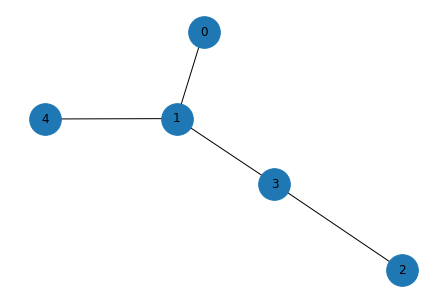

In [10]:
nx.draw(mst_graph, with_labels=True, node_size=1000)
plt.show()

## A*
Pour implémenter l'algorithme A*, nous avons défini 2 classes : Etat et AStar2 qui figurent dans la cellule ci-dessous

In [11]:
class Etat:
    # constructeur de la classe Etat
    # pere : un Etat
    # etat : un entier pour le numéro du sommet correspondant à l'Etat
    # distance : somme des distances depuis le départ jusqu'à cette ville
    def __init__(self, pere, etat, distance):
        self.pere = pere
        self.etat = etat
        self.distance = distance #distance parcourue du début jusqu'à cet état -> g(n)
    
    # return True si toutes les villes ont été parcourues pour cet Etat en remontant sur tous les pères
    def is_solved(self, graphe):
        path = self.liste_peres()
        if(set(path) == set(list(graphe.nodes()))):
            return True
        return False
    
    # retourne la listes de toutes les villes précédents cet Etat
    def liste_peres(self):
        e = self
        path = [e.etat]
        while(e.pere != -1):
            path.append(e.pere.etat)
            e = e.pere
        return path

class AStar2:
    # constructeur de la classe AStar2, prend un graphe G d networkx en paramètre
    def __init__(self, G):
        self.graphe = G.copy()
        #chemin + court le même peu importe le sommet de départ car boucle
        self.racine = Etat(-1, list(self.graphe.nodes)[0], 0)
        # frontier = dict(n, f(n))
        self.frontier = {self.racine: self.f(self.racine)}
    
    # retourne le résultat de f(n) = g(n) + h(n)
    def f(self, n):
        return self.g(n) + self.heuristique(n)
    
    # retourne le résultat de g(n) soit la somme des distances précédentes d'un état n depuis le départ
    def g(self, n):
        return n.distance
    
    # retourne la valeur de l'heuristique h(n) pour un état n
    def heuristique(self, n):
        G = self.graphe.copy()
        path = n.liste_peres()
        path.remove(0)
        if(n.etat != 0):
            path.remove(n.etat)
        for node in path:
            G.remove_node(node)
        mst_graph = nx.minimum_spanning_tree(G, weight='weight', algorithm='prim')
        distance = 0
        for edge in mst_graph.edges(data=True):
            distance += edge[2]["weight"]
        return distance
    
    # retourne le meilleur élément de frontier tout en le retirant
    def my_pop(self):
        mini = sys.maxsize
        i = -1
        for f in self.frontier.items():
            if f[1] < mini:
                mini = f[1]
                i = f[0]
        self.frontier.pop(i)
        return i
    
    # retourne une liste d'actions possibles et leurs valeurs f(n) associées étant donné l'état actuel
    # contenu dans self.racine
    def actions(self):
        actions = {}
        for edge in self.graphe.edges(self.racine.etat, data=True):
            if(edge[1] not in self.racine.liste_peres()):
                action = Etat(self.racine, edge[1], self.racine.distance + edge[2]["weight"])
                actions.update({action: self.f(action)})
        return actions
    
    # la fonction result met à jour un état de la frontier si on a trouvé un état identique
    # avec un meilleur f(n)
    def result(self, action, f_n):
        self.frontier.update({action: f_n})
    
    # fonction principale de la classe qui exécute l'algorithme A* 
    def solve(self):
        #tant qu'il y a des villes dans frontier c'est qu'on a pas parcouru toutes les villes
        while(not self.racine.is_solved(self.graphe) and len(self.frontier) > 0):
            self.racine = self.my_pop()
            for action, f_n in self.actions().items():
                etat_in_front = []
                for etat_f in list(self.frontier.keys()): #on récupère les états des actions
                    etat_in_front.append(etat_f.etat)
                if(action.etat not in etat_in_front): #si pas dans frontier, on rajoute
                    self.result(action, f_n)
                elif(action.etat in etat_in_front): #màj dans frontier si action mieux que celle dans frontier
                    for key in self.frontier.keys():
                        if(key.etat == action.etat):
                            frontier_fn = self.frontier[key]
                            key_f = key
                            break
                    if(frontier_fn > f_n):
                        self.frontier.pop(key_f)
                        self.result(action, f_n)
        if(self.racine.is_solved(self.graphe)):
            e = self.racine
            path = self.racine.liste_peres()
            path.insert(0, 0) #on rajoute le sommet de départ qui est 0 dans le trajet
            distance = nx.path_weight(self.graphe, path, weight="weight") #pour récupérer la bonne distance
            print("Le meilleur chemin avec l'algorithme A* est " + str(path) + " ce chemin a une distance totale de " + str(distance))

In [12]:
a_star2 = AStar2(graphe)
a_star2.solve()

Le meilleur chemin avec l'algorithme A* est [0, 2, 3, 1, 4, 0] ce chemin a une distance totale de 15


## Recherche locale : genetic algorithm

In [7]:
import numpy as np
import random 

class Genetic:

    #constructeur de la classe
    def __init__(self, G, taille_population='None', nbr_iteration=10):
        self.graphe = G.copy()
        if(taille_population=='None'):
            self.taille_pop = len(self.graphe.edges)
        else:
            self.taille_pop = taille_population
        self.nbr_iter = nbr_iteration
        
    #definir le score de chaque chemin
    def fitness(self, chemin):
        score = 0
        for i in range(len(chemin)-1):
            score += self.graphe[chemin[i]][chemin[i+1]]['weight']
        score += self.graphe[chemin[len(chemin)-1]][chemin[0]]['weight']
        return score 

    #choix des reproducteurs : on prend ceux qui ont le meilleur score
    #on prend 1/3 de la population pour la reproduction
    def selection(self, pop):
        selec_pop = []
        scores = []
        for i in range(len(pop)):
            data = []
            data.append(i)
            data.append(self.fitness(pop[i]))
            scores.append(data)
        scores_tries = sorted(scores, key=lambda item:(item [1]))
        for i in range(round(len(pop)/3)):
            selec_pop.append(pop[scores_tries[i][0]])
        return selec_pop

    #on prend au hasard un individu dans les sélectionnés pour être reproducteurs
    def random_selec(self, pop):
        i = random.randint(0, len(pop)-1)
        return pop[i]

    #on prend les caracteristiques du pere jusqu'au point de croisement ici (sommet/3)
    def reproduce(self, pere, mere):
        point_crois = round(len(self.graphe.nodes)/3)
        child = []
        sommets = np.arange(len(self.graphe.nodes)) 
        for i in range(point_crois):
            child.append(pere[i])
            sommets = np.setdiff1d(sommets, pere[i])
        for i in range(point_crois, len(mere)):
            if(mere[i] in sommets):
                child.append(mere[i])
                sommets = np.setdiff1d(sommets, mere[i])
            else :
                s = sommets[random.randint(0, len(sommets)-1)]
                child.append(s)
                sommets = np.setdiff1d(sommets, s)
        return child

    #on applique la mutation on inversant 2 sommets voisins
    def mutate(self, individu):
        i = random.randint(0, len(individu)-1)
        temp = individu[i]
        if(i+1==len(individu)):
            individu[i] = individu[0]
            individu[0] = temp
        else: 
            individu[i] = individu[i+1]
            individu[i+1] = temp
        return individu 

    def solve(self):
        #size of the population : nbr arretes
        size_pop = int(self.taille_pop)
        population = []

        #generation de la population initiale  
        for i in range(size_pop):
            sommets = np.arange(len(self.graphe.nodes)) 
            np.random.shuffle(sommets)
            chemin = sommets.tolist()
            population.append(chemin)

        #evolution de la population
        iterations = 0
        while(iterations < int(self.nbr_iter)):
            new_population = []
            selec_pop = self.selection(population)
            for i in range(size_pop):
                pere = self.random_selec(selec_pop)
                mere = self.random_selec(selec_pop)
                child = self.reproduce(pere, mere)
                proba_mutation = random.randint(1, 100)
                if(proba_mutation<10):
                    child = self.mutate(child)
                new_population.append(child)
            population = new_population
            iterations += 1


        #on prend le meilleur individu
        meilleure_pop = self.selection(population)
        distance = self.fitness(meilleure_pop[0])
        solution = meilleure_pop[0]
        solution.append(meilleure_pop[0][0])
        #on sélectionne celui qui est en haut du classement
        print("Le meilleur chemin avec l'algorithme génétique est " + str(solution) + ". Ce chemin a une distance totale de " + str(distance))

In [12]:
genetic_algorithm = Genetic(graphe)
genetic_algorithm.solve()

genetic_algorithm_2 = Genetic(graphe, taille_population=20, nbr_iteration=50)
genetic_algorithm_2.solve()

Le meilleur chemin avec l'algorithme génétique est [2, 0, 1, 4, 3, 2]. Ce chemin a une distance totale de 16
Le meilleur chemin avec l'algorithme génétique est [3, 1, 4, 0, 2, 3]. Ce chemin a une distance totale de 15


## IDA *
Implémentation de l'algorithme IDA* dans la classe IDA_star ci-dessous.

On réutilise la classe Etat à l'identique

In [14]:
class Etat:
    # constructeur de la classe Etat
    # pere : un Etat
    # etat : un entier pour le numéro du sommet correspondant à l'Etat
    # distance : somme des distances depuis le départ jusqu'à cette ville
    def __init__(self, pere, etat, distance):
        self.pere = pere
        self.etat = etat
        self.distance = distance #distance parcourue du début jusqu'à cet état -> g(n)
    
    # return True si toutes les villes ont été parcourues pour cet Etat en remontant sur tous les pères
    def is_solved(self, graphe):
        path = self.liste_peres()
        if(set(path) == set(list(graphe.nodes()))):
            return True
        return False
    
    # retourne la listes de toutes les villes précédents cet Etat
    def liste_peres(self):
        e = self
        path = [e.etat]
        while(e.pere != -1):
            path.append(e.pere.etat)
            e = e.pere
        return path

class IDA_star:
    # constructeur de la classe IDA_star, prend un graphe de networkx en paramètre
    def __init__(self, G):
        self.graphe = G.copy()
        #chemin + court le même peu importe le sommet de départ car boucle
        self.racine = Etat(-1, list(self.graphe.nodes)[0], 0)
        #frontier = dict(n, f(n))
        self.frontier = {self.racine: self.f(self.racine)}
        self.limite = self.f(self.racine)
    
    # retourne g(n) + h(n) étant donné un état n
    def f(self, n):
        return self.g(n) + self.heuristique(n)
    
    # retourne le résultat de g(n) soit la somme des distances précédentes d'un état n depuis le départ
    def g(self, n):
        return n.distance
    
    # retourne h(n) soit l'heuristique associé à cet état n
    def heuristique(self, n):
        G = self.graphe.copy()
        path = n.liste_peres()
        path.remove(0)
        if(n.etat != 0):
            path.remove(n.etat)
        for node in path:
            G.remove_node(node)
        mst_graph = nx.minimum_spanning_tree(G, weight='weight', algorithm='prim')
        distance = 0
        for edge in mst_graph.edges(data=True):
            distance += edge[2]["weight"]
        return distance
    
    # retourne le meilleur état dans frontier tout en le retirant de frontier, et met à jour la limite
    def my_pop(self):
        mini = sys.maxsize
        i = -1
        for f in self.frontier.items():
            if f[1] < mini:
                mini = f[1]
                i = f[0]
        self.frontier.pop(i)
        if(f[1] > self.limite):
            self.limite = f[1]
        return i
    
    # retourne une liste des états-actions possible à partir de la ville actuelle ainsi que le f(n) associé
    def actions(self):
        actions = {}
        for edge in self.graphe.edges(self.racine.etat, data=True):
            if(edge[1] not in self.racine.liste_peres()):
                action = Etat(self.racine, edge[1], self.racine.distance + edge[2]["weight"])
                actions.update({action: self.f(action)})
        return actions
    
    # met à jour frontier avec l'action et le f(n) passés en paramètres
    def result(self, action, f_n):
        self.frontier.update({action: f_n})
    
    # fonction principale qui implémente l'algorithme
    def solve(self):
        while(not self.racine.is_solved(self.graphe) and len(self.frontier) > 0):
            self.racine = self.my_pop()
            for action, f_n in self.actions().items():
                etat_in_front = []
                for etat_f in list(self.frontier.keys()):
                    etat_in_front.append(etat_f.etat)
                if(action.etat not in etat_in_front):
                    self.result(action, f_n)
                elif(action.etat in etat_in_front): #màj dans frontier si action mieux que celle dans frontier
                    for key in self.frontier.keys():
                        if(key.etat == action.etat):
                            frontier_fn = self.frontier[key]
                            key_f = key
                            break
                    if(frontier_fn > f_n):
                        self.frontier.pop(key_f)
                        self.result(action, f_n)
        if(self.racine.is_solved(self.graphe)):
            e = self.racine
            path = self.racine.liste_peres()
            path.insert(0, 0)
            distance = nx.path_weight(self.graphe, path, weight="weight")
            print("Le meilleur chemin avec l'algorithme IDA* est " + str(path) + " ce chemin a une distance totale de " + str(distance))

In [15]:
ida_star = IDA_star(graphe)
ida_star.solve()

Le meilleur chemin avec l'algorithme IDA* est [0, 2, 3, 1, 4, 0] ce chemin a une distance totale de 15
